In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import sys
sys.path.append('/cpfs04/user/hanyujin/rule-gen/rule_tokenizer')
# from torchvision import transforms
# from utils.data import random_crop_arr, center_crop_arr
import ruamel.yaml as yaml
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
sys.path.append('/cpfs04/user/hanyujin/rule-gen/rule_tokenizer')
from utils.model import build_tokenizer
from torchvision.datasets import DatasetFolder
vae_config =  "/cpfs04/user/hanyujin/rule-gen/rule_tokenizer/configs/in1k/exp007-aediff-16.yaml"
vae_ckpt = "/cpfs04/user/hanyujin/rule-gen/experiments/tokenizer/mirror-exp001-aediff-16/checkpoints/0040000.pt"
vae, vae_model, vae_embed_dim, dit_input_size, latents_bias, latents_scale, vae_1d = build_tokenizer(vae_config, vae_ckpt)

/root/miniconda3/envs/yjenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-23 11:41:18.167623: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-23 11:41:18.180791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-23 11:41:18.200374: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-23 11:41:18.20

<All keys matched successfully>


In [2]:
if vae_config is not None:
    with open(vae_config, 'r', encoding='utf-8') as f:
        file_yaml = yaml.YAML()
        config_args = file_yaml.load(f)

vae.cuda().eval()

AEDiffModel(
  (encoder): TimmViTEncoder(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(4, 4), stride=(4, 4))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=76

In [3]:
import torch
all_latents = []

for i in range(10):
    # 1. 生成一张随机图像，形状为 (64, 64, 3)
    #    但 PyTorch 通常使用 (3, 64, 64) 的通道优先格式
    img_np = torch.randn(64, 64, 3).cuda()  # 先用 (H, W, C) 形式
    img_pt = img_np.permute(2, 0, 1).unsqueeze(0)  
    # permute(2,0,1) 把 (64,64,3) -> (3,64,64)
    # unsqueeze(0) 在最前面加一个 batch 维度 -> (1,3,64,64)
    
    # 2. 调用 VAE 的 encode 函数
    with torch.no_grad():
        latent_sample_ext, _, _ = vae.encode(img_pt)
        
        # 3. 将编码结果放到 CPU 并转换成 numpy，再存入列表
        all_latents.append(latent_sample_ext.cpu().numpy())

noise_latents = np.concatenate(all_latents, axis=0) 


In [6]:
print(torch.tensor(noise_latents).shape)

torch.Size([10, 256, 32])


In [9]:
file_path = "/cpfs04/user/hanyujin/rule-gen/rule_tokenizer/eval/latents/mirror-AE-Diff-16.npz"
data = np.load(file_path, allow_pickle=True)
features = torch.tensor(data["latents"])  # 读取 "features" 数组

In [12]:
features.shape

torch.Size([55200, 256, 32])

latent_sample : torch.Size([10, 256, 32])


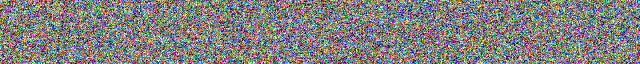

In [8]:
num = 10
# indices = torch.randperm(features.shape[0])[:num]  # 随机选择 num 个索引
latent_sample = torch.tensor(noise_latents).cuda()
print("latent_sample :",latent_sample.shape )
with torch.no_grad():
    decoded_img = vae.decode(latent_sample)  # 形状 [1, 3, 256, 256]
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
from torchvision.utils import make_grid
# 显示图片
image = make_grid(decoded_img, nrow=num//1, padding=0, pad_value=1.0)
image = (image + 1) / 2  # 归一化到 [0,1]
img_np = image.clamp(0, 1).permute(1, 2, 0).mul(255).byte().cpu().numpy()
Image.fromarray(img_np).show()